In [1]:
#--------------------------------------------------------------------------------
#--                                                                            --
#--               Federal University of Santa Catarina UFSC                    --
#--                                Brazil                                      --
#--                                                                            --
#--------------------------------------------------------------------------------
#--                                                                            --
#-- File        : Atividade_3.py                                               --
#-- Authors     : Luis Felipe de Deus
#--             : Guilberth Matos 
#--             : Jéferson Cansi Pedroso                                       --
#--                                                                            -- 
#--------------------------------------------------------------------------------
#--                                                                            --
#-- Created     : 01 Jun 2021                                                  --
#-- Update      : 05 Jun 2021                                                  --
#--------------------------------------------------------------------------------

### Import the libraries which we need

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd

from scipy import signal 
import scaleogram as scg
from scipy.signal import butter, lfilter, lfilter_zi
import wfdb

### Auxiliary functions

In [3]:
# Butterworth filter
def butter_bandpass(lowcut, highcut, sRate, order=5):
    nyq = 0.5 * sRate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
#end-def

# This function will apply the filter considering the initial transient.
def butter_bandpass_filter_zi(data, lowcut, highcut, sRate, order=5):
    b, a = butter_bandpass(lowcut, highcut, sRate, order=order)
    zi = lfilter_zi(b, a)
    y,zo = lfilter(b, a, data, zi=zi*data[0])
    return y
#end-def

### Read data

In [4]:
#You should put the CSV into a folder named UFSC_Data 
# or if it is in the root folder just use folder=''
folder = 'UFSC_Data/' 

dataFrame = pd.read_csv(folder+'ppg-ecg.csv', delimiter=';')
dataFrame = dataFrame.drop(0,axis=0) #Drop the first row, which has the units
dataFrame = dataFrame.reset_index() #Reset the index to start at pos 0
dataFrame = dataFrame.drop(['index'],axis=1) #Becuase of the above operation there is a column called 'index'
sps = 125 #Sampling rate 1/0.008

dataFrame.head()


,'PLETH ','III ',sample_rate=8ms
0,-0.11500000,-0.06950000,NaN
1,-0.11500000,-0.06800000,NaN
2,-0.13650000,-0.05900000,NaN
3,-0.15100000,-0.04200000,NaN
4,-0.17950000,-0.01650000,NaN


In [5]:
#Get ECG data
ECG_raw = np.asarray(dataFrame["'III '"], dtype=float)

In [6]:
#Get PPG data
'''
Because there are samples in the PPG data that are corrupted we should
clean the samples, to do so, we can easily do a 'for each' and use 'try' and 'except'.
Every time its impossible change the sample from string to float we're gonna receive an exeption
'''
PPG_raw = []
for i in dataFrame["'PLETH '"]:
    try:
        PPG_raw.append(float(i))
    except:
        pass

## Preprocessing Stage

### Filtering

In [7]:
#Apply a band pass filter - butterworth
ECGf = butter_bandpass_filter_zi(ECG_raw, 0.5, 25, sps, 4)
#
PPGf = butter_bandpass_filter_zi(PPG_raw, 0.5, 8, sps, 4)

### Window

In [8]:
'''
In order to apply the analysis we should divide the signal into smaller windows.
Then we can highlight some important events during the time series
'''
seconds = 5 #Size of window in seconds
n_samples = seconds * sps #Size in number of samples

start = 1000 #Sample where we should start (just to avoid starting in sample 0)
ECG_window = ECGf[start : start+n_samples] #ECG window will be an array from start until start+n_samples
PPG_window = PPGf[start : start+n_samples] #PPG window will be an array from start until start+n_samples

<IPython.core.display.Javascript object>


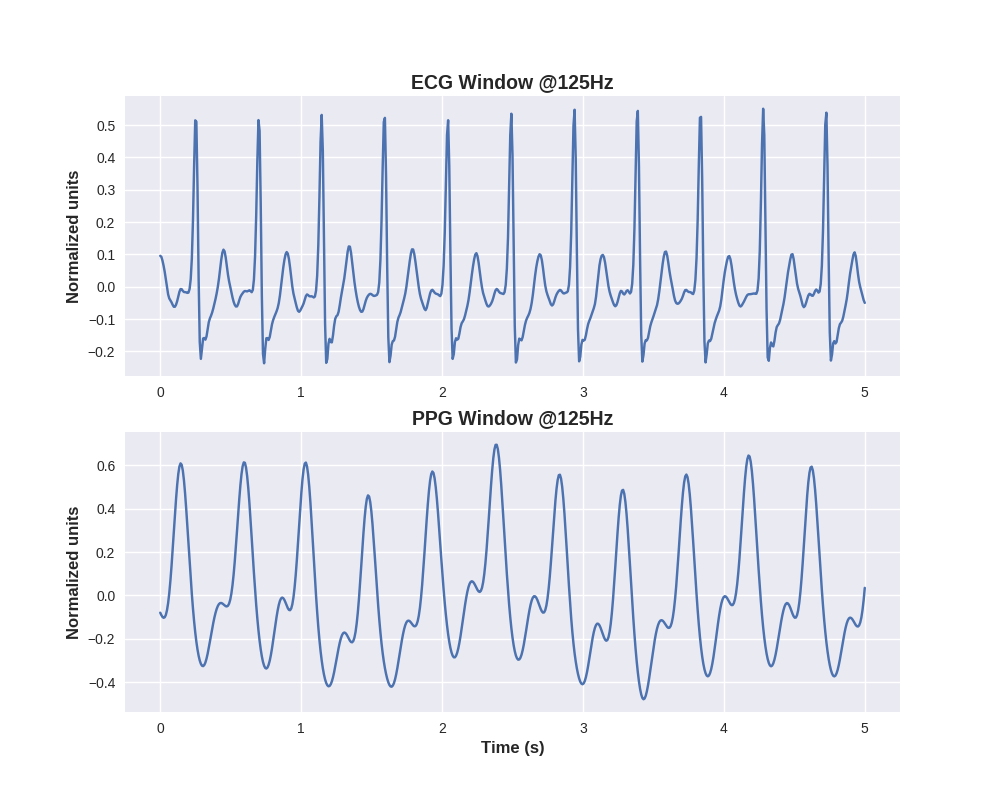

In [9]:
%matplotlib notebook 
#%matplotlib inline #In case you're working with Google Colab you may have to replace the above line with this one

#Plot the ECG and PPG Windows in time domain

plt.style.use('seaborn')
#Create two plots at the same figure  - 2 rows, 1 column
fig, axs = plt.subplots(2,1,figsize = (10,8))

#Create x-axis
ax = np.linspace(0, len(ECG_window)/sps, len(ECG_window), endpoint=True)

#Plot
axs[0].plot(ax, ECG_window)
axs[0].set_ylabel('Normalized units', fontsize = 12, fontweight = 'bold')
axs[0].set_title('ECG Window @125Hz', fontsize = 14, fontweight = 'bold')

axs[1].plot(ax, PPG_window)
axs[1].set_ylabel('Normalized units', fontsize = 12,fontweight = 'bold')
axs[1].set_xlabel('Time (s)', fontsize = 12,fontweight = 'bold')
axs[1].set_title('PPG Window @125Hz', fontsize = 14, fontweight = 'bold')
plt.show()

### Padding

In [10]:
#We can apply some padding in the signal in order to avoid the boundaries
N=sps
ECG_window = np.pad(ECG_window,(N,N), 'constant')

PPG_window = np.pad(PPG_window,(N,N), 'constant')

### FFT Example

<IPython.core.display.Javascript object>


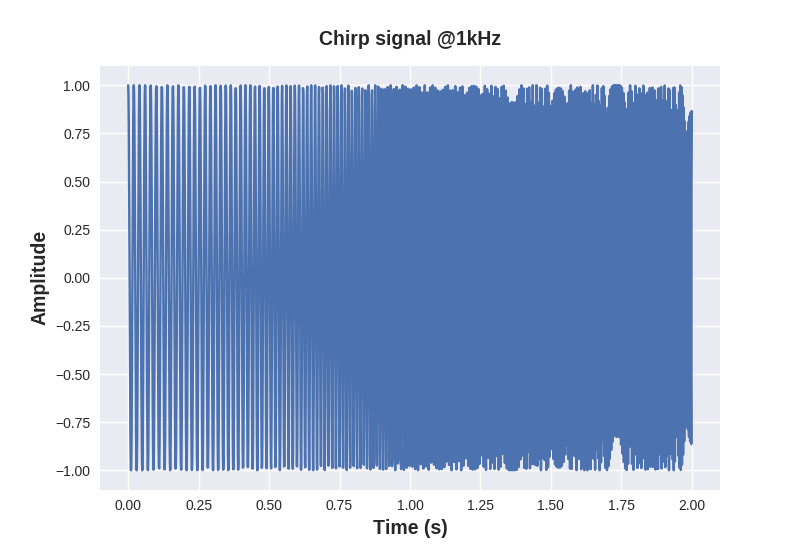

<IPython.core.display.Javascript object>


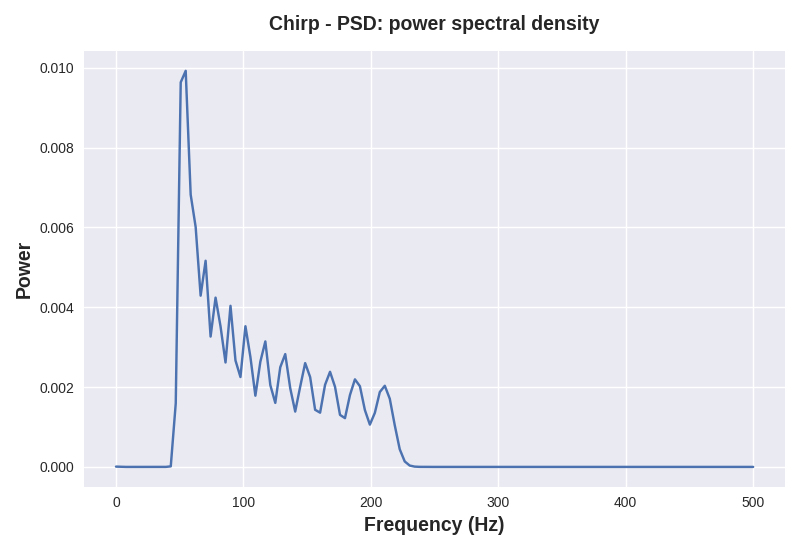

<IPython.core.display.Javascript object>


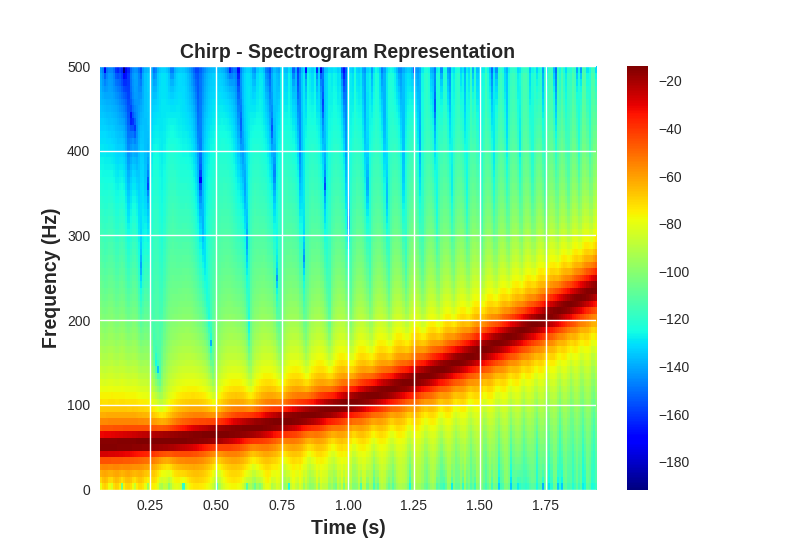

In [11]:
'''
First of all lets plote a 'dummy-example' to better understand the method.
This example will create a 'chirp' signal with a quadratic function.
It is a cosine signal which starts in 50 Hz and will increase until 250 Hz
'''

%matplotlib notebook
dt= 0.001 #Signal period
t = np.arange(0,2,dt)
f0 = 50  #Initial frequency
f1 = 250 #Ending frequency
t1 = 2 

#Signal
x = np.cos(2*np.pi*t*(f0 + (f1-f0) * np.power(t,2)/(3*t1**2)))

fs = 1/dt #Sampling frequency

#Time axis
ax = np.linspace(0, len(x)/fs, len(x), endpoint=True)

## Plot signal in time domain
fig = plt.figure()
plt.plot(ax, x)
plt.title('Chirp signal @1kHz', fontsize = 14, y = 1.03,fontweight = 'bold')
plt.xlabel('Time (s)', fontsize = 14,fontweight = 'bold')
plt.ylabel('Amplitude', fontsize = 14,fontweight = 'bold')
plt.show()

#Apply welch's method to compute PSD
fig_3 = plt.figure()
freqs, psd = signal.welch(x, fs=fs)

#Plot Power Spectral Density
plt.plot(freqs, psd)
plt.title('Chirp - PSD: power spectral density', fontsize = 14, y = 1.03,fontweight = 'bold')
plt.xlabel('Frequency (Hz)', fontsize = 14,fontweight = 'bold')
plt.ylabel('Power', fontsize = 14,fontweight = 'bold')
plt.tight_layout() 

#Calculate and plot spectrogram using FFT
fig_2 = plt.figure()
plt.specgram(x, NFFT=128, Fs=fs, noverlap=120,scale='dB', cmap='jet')
plt.colorbar()
plt.title('Chirp - Spectrogram Representation', fontsize = 14, fontweight = 'bold')
plt.xlabel('Time (s)', fontsize = 14,fontweight = 'bold')
plt.ylabel('Frequency (Hz)', fontsize = 14,fontweight = 'bold')
plt.show()


## Wavelet Analysis - Scalogram

### Wavelet-mother chosen : Complex Morlet

<IPython.core.display.Javascript object>


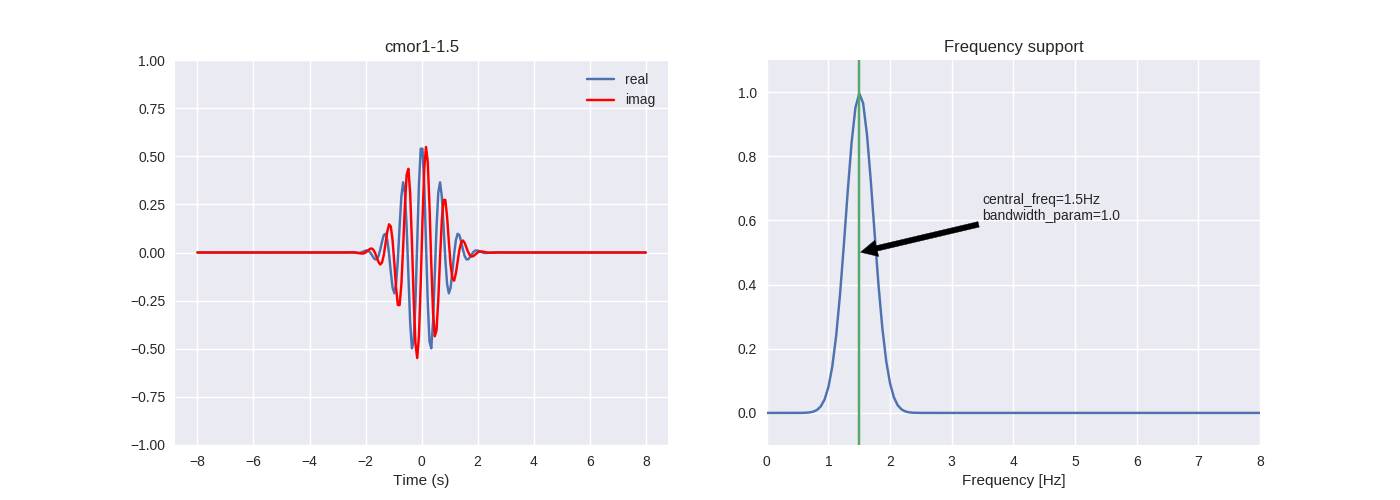

In [12]:
%matplotlib notebook

#First, plot the chosen wavelet-mother - Morlet Complex
axes = scg.plot_wav('cmor1-1.5', figsize=(14,5))

### ECG Window

<IPython.core.display.Javascript object>


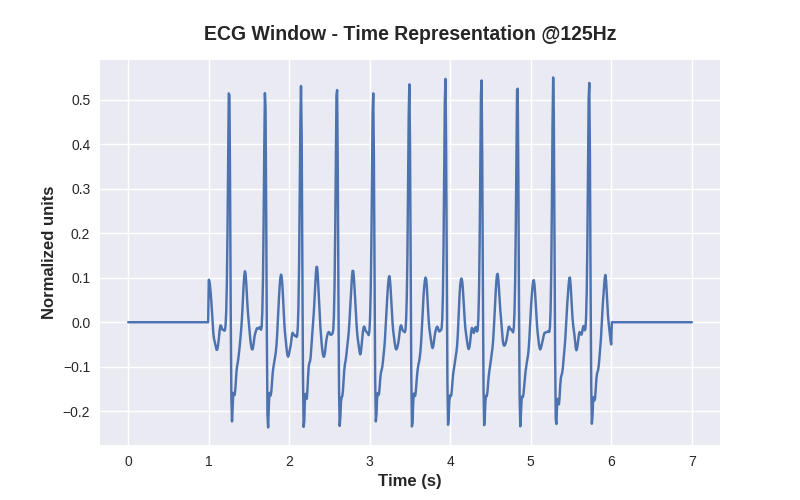

<IPython.core.display.Javascript object>


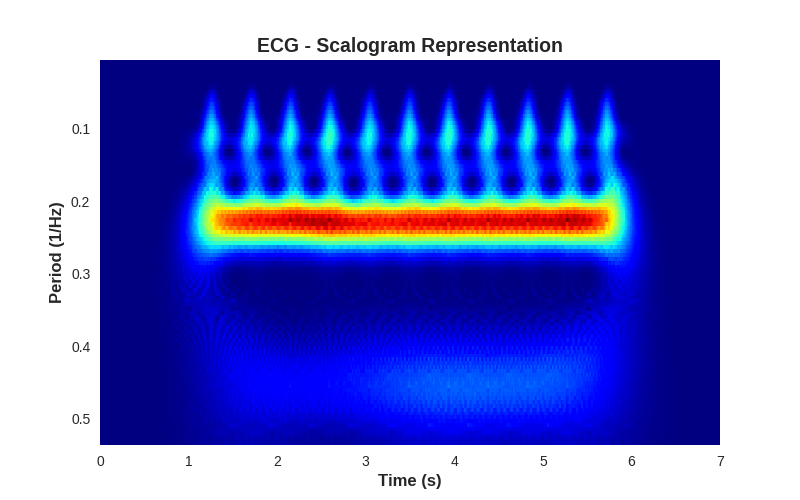

In [13]:
%matplotlib notebook
#Now lets plot the ECG window with the Wavelet representation

#Create time domain representation
fig = plt.figure(figsize = (8,5))
#Create time axis
ax = np.linspace(0, len(ECG_window)/sps, len(ECG_window), endpoint=True)

plt.plot(ax, ECG_window)
plt.ylabel('Normalized units', fontsize = 12,fontweight = 'bold')
plt.xlabel('Time (s)', fontsize = 12,fontweight = 'bold')
plt.title('ECG Window - Time Representation @125Hz', fontsize = 14, y = 1.03,fontweight = 'bold')


wavelet = 'cmor1-1.5'  #Wavelet-mother
scale = np.arange(1, 100, 1) #The scale parameter its how we will dilate the wavelet onto the signal
time = np.arange(len(ECG_window))*(1/sps)  #Time represents how we'd like the time representation

#Create Scalogram Plot
ax2 = scg.cws(time, ECG_window, scales=scale, wavelet=wavelet,\
            figsize=(8, 5),yaxis='period',spectrum='power', cmap="jet", cbar=None, coi=False, ylabel='', xlabel='',\
            title='Scalogram Representation')
ax2.set_xlabel('Time (s)', fontsize = 12,fontweight = 'bold')
ax2.set_ylabel('Period (1/Hz)', fontsize = 12,fontweight = 'bold')
ax2.set_title('ECG - Scalogram Representation', fontsize = 14,fontweight = 'bold')

plt.show()

### PPG Window

In [14]:
#We can create a gap in the PPG signal, for example by introducing 0's in a certain part
half_PPG = int(len(PPG_window)/2)
fake_signal = np.zeros(len(PPG_window)+500)

fake_signal[0:half_PPG] = PPG_window[0:half_PPG]
fake_signal[half_PPG+500:] = PPG_window[half_PPG:]


<IPython.core.display.Javascript object>


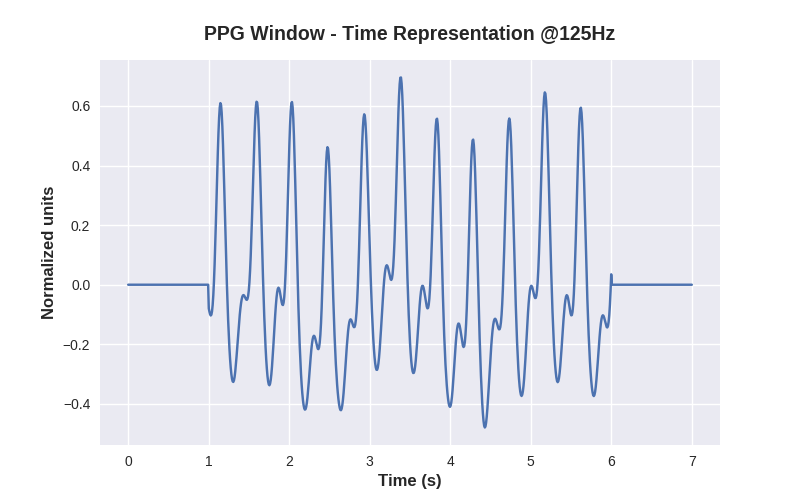

<IPython.core.display.Javascript object>


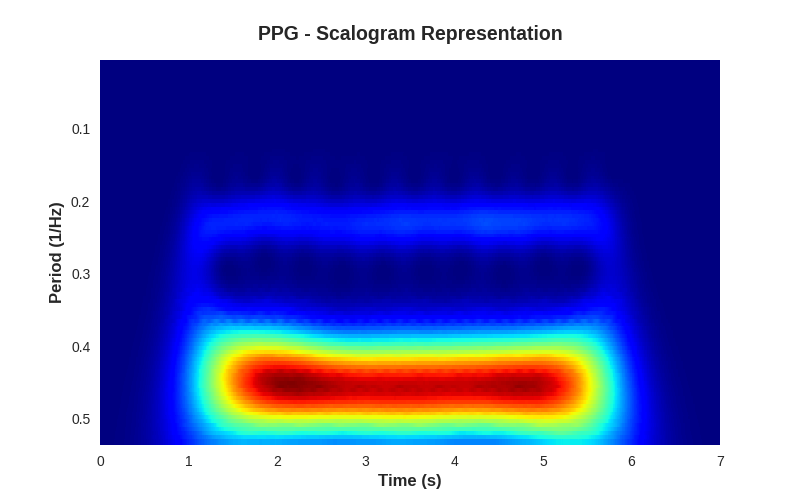

In [15]:
%matplotlib notebook

#If you'd like to plot the PPG signal with a gap
#PPG_window = fake_signal

#Create time domain representation
fig = plt.figure(figsize = (8,5))
ax = np.linspace(0, len(PPG_window)/sps, len(PPG_window), endpoint=True)
plt.plot(ax, PPG_window)
plt.ylabel('Normalized units', fontsize = 12,fontweight = 'bold')
plt.xlabel('Time (s)', fontsize = 12,fontweight = 'bold')
plt.title('PPG Window - Time Representation @125Hz', fontsize = 14, y = 1.03,fontweight = 'bold')

wavelet = 'cmor1-1.5'  #Wavelet-mother
scale = np.arange(1, 100, 1) #The scale parameter its how we will dilate the wavelet onto the signal
time = np.arange(len(PPG_window))*(1/sps)  #Time represents how we'd like the time representation

#Create Scalogram
ax2 = scg.cws(time, PPG_window, scales=scale, wavelet=wavelet,\
            figsize=(8, 5),yaxis='period',spectrum='power', cmap="jet", cbar=None, coi=False, ylabel='', xlabel='',\
            title='Scalogram Representation')
ax2.set_xlabel('Time (s)', fontsize = 12,fontweight = 'bold')
ax2.set_ylabel('Period (1/Hz)', fontsize = 12,fontweight = 'bold')
ax2.set_title('PPG - Scalogram Representation', fontsize = 14, y = 1.03,fontweight = 'bold')


plt.show()

## FFT Analysis - Spectrogram

<IPython.core.display.Javascript object>


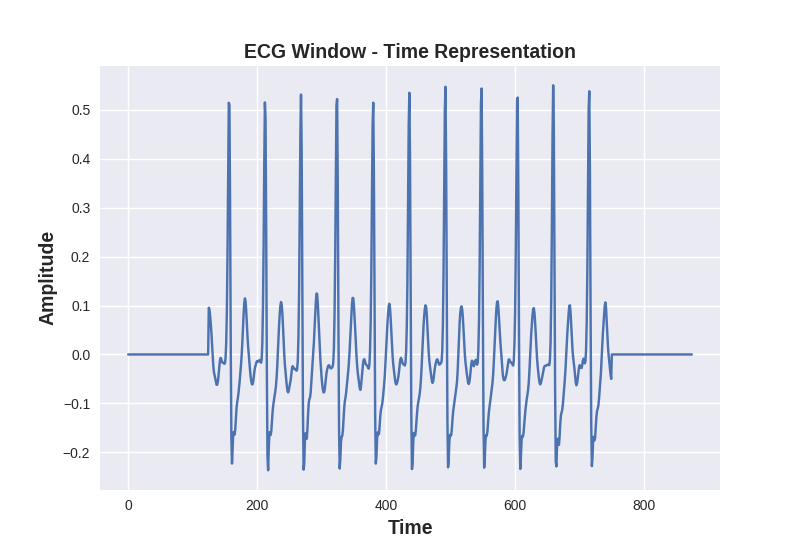

<IPython.core.display.Javascript object>


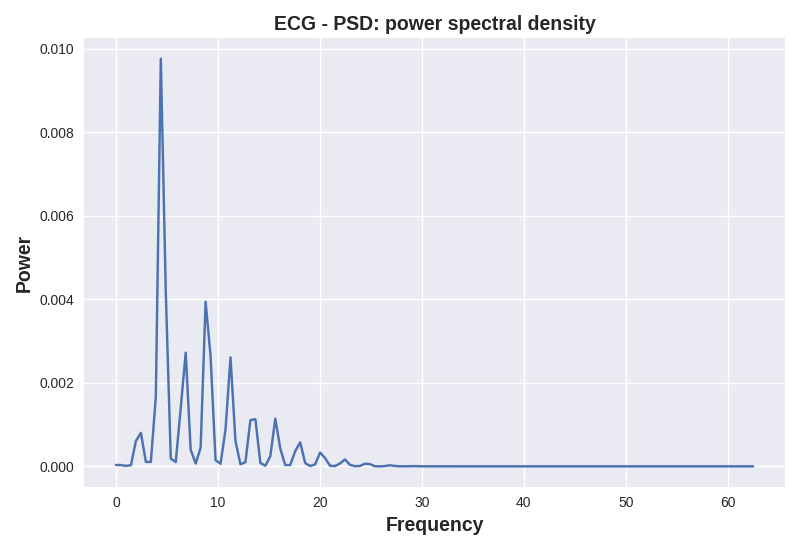

<IPython.core.display.Javascript object>


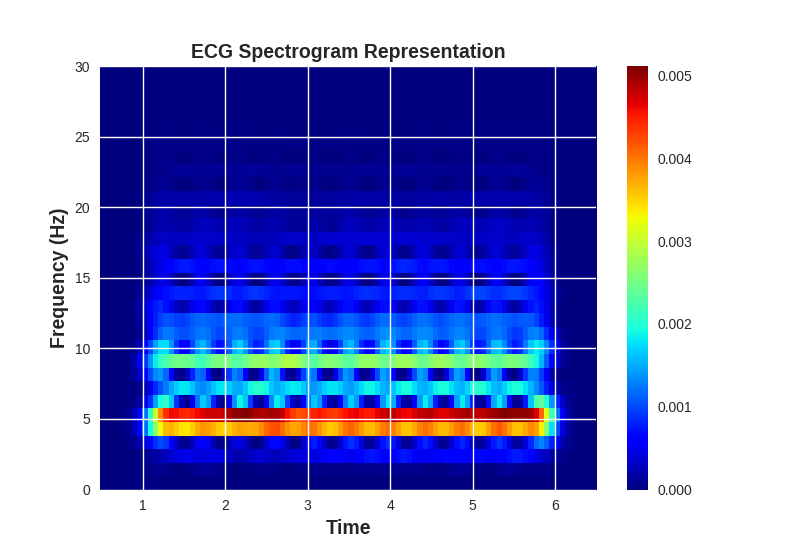

In [16]:
%matplotlib notebook

#Plot time domain
fig = plt.figure()
plt.plot(ECG_window)
plt.show()
plt.title('ECG Window - Time Representation', fontsize = 14,fontweight = 'bold')
plt.xlabel('Time', fontsize = 14,fontweight = 'bold')
plt.ylabel('Amplitude', fontsize = 14,fontweight = 'bold')

#Create and plot the PSD
fig_3 = plt.figure()
freqs, psd = signal.welch(ECG_window, fs=sps)

plt.plot(freqs, psd)
plt.title('ECG - PSD: power spectral density', fontsize = 14,fontweight = 'bold')
plt.xlabel('Frequency', fontsize = 14,fontweight = 'bold')
plt.ylabel('Power', fontsize = 14,fontweight = 'bold')
plt.tight_layout() 

#Plot the Spectrogram
fig_2 = plt.figure()
plt.specgram(ECG_window,NFFT=128, Fs=sps, noverlap=120, scale='linear', cmap='jet')
plt.colorbar()
plt.title('ECG Spectrogram Representation', fontsize = 14, fontweight = 'bold')
plt.xlabel('Time', fontsize = 14,fontweight = 'bold')
plt.ylabel('Frequency (Hz)', fontsize = 14,fontweight = 'bold')
plt.ylim(0,30)
plt.show()

<IPython.core.display.Javascript object>


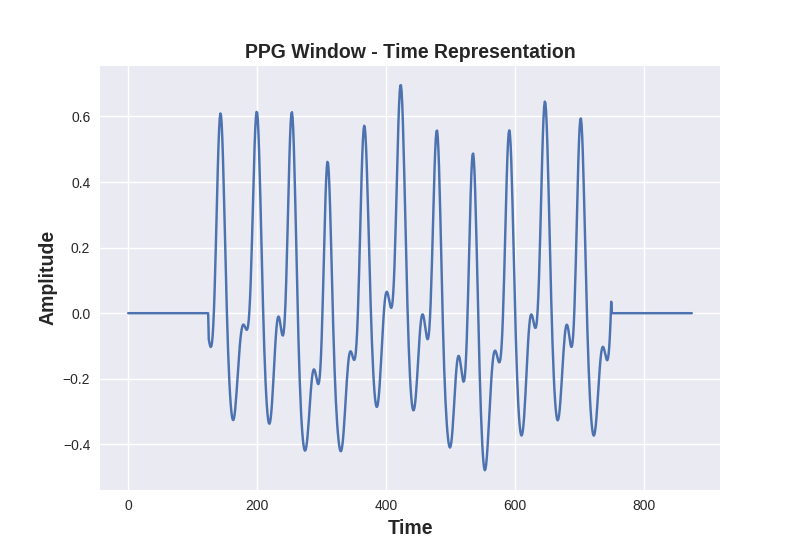

<IPython.core.display.Javascript object>


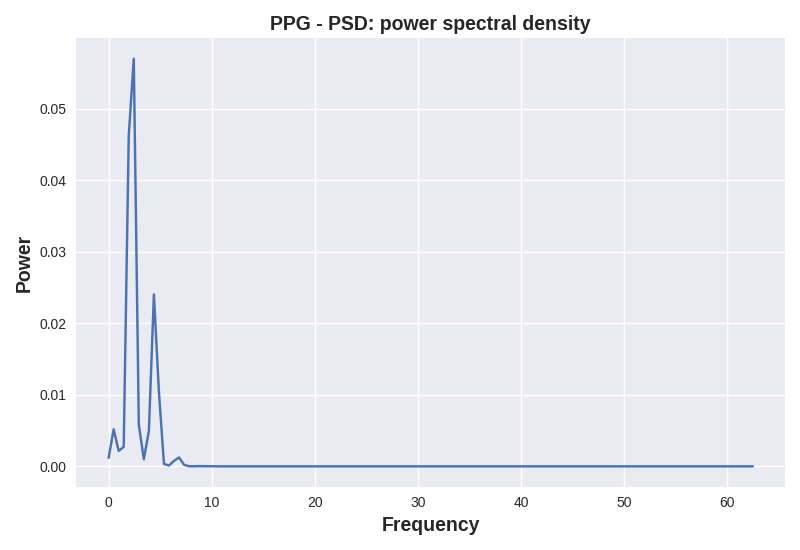

<IPython.core.display.Javascript object>


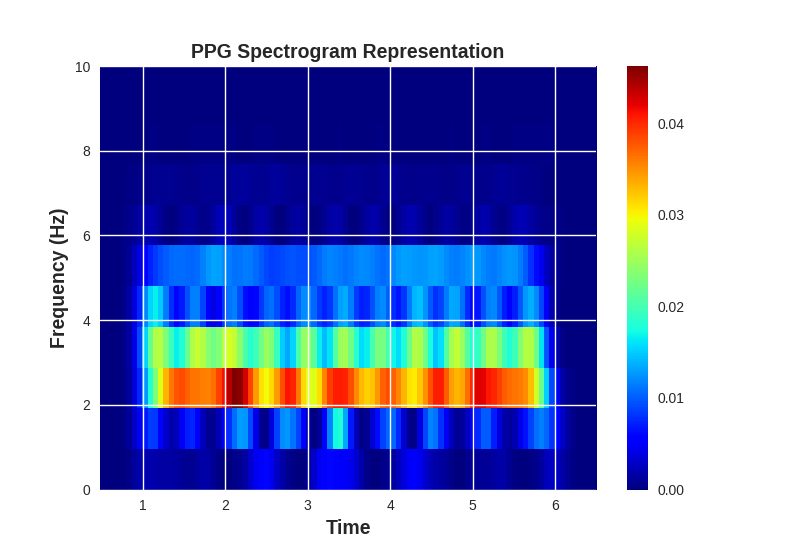

In [17]:
%matplotlib notebook

#Plot time domain
fig = plt.figure()
plt.plot(PPG_window)
plt.show()
plt.title('PPG Window - Time Representation', fontsize = 14,fontweight = 'bold')
plt.xlabel('Time', fontsize = 14,fontweight = 'bold')
plt.ylabel('Amplitude', fontsize = 14,fontweight = 'bold')

#Create and plot the PSD
fig_3 = plt.figure()
freqs, psd = signal.welch(PPG_window, fs=sps)

plt.plot(freqs, psd)
plt.title('PPG - PSD: power spectral density', fontsize = 14,fontweight = 'bold')
plt.xlabel('Frequency', fontsize = 14,fontweight = 'bold')
plt.ylabel('Power', fontsize = 14,fontweight = 'bold')
plt.tight_layout() 

#Plot the Spectrogram
fig_2 = plt.figure()
plt.specgram(PPG_window,NFFT=128, Fs=sps, noverlap=120, scale='linear', cmap='jet')
plt.colorbar()
plt.title('PPG Spectrogram Representation', fontsize = 14, fontweight = 'bold')
plt.xlabel('Time', fontsize = 14,fontweight = 'bold')
plt.ylabel('Frequency (Hz)', fontsize = 14,fontweight = 'bold')
plt.ylim(0,10)
plt.show()

### Atrial Fibrillation situation - Example

### Read data - Sample from Physionet AFDB

### AFIB ECG -> Absence of P wave, Irregular RR interval, multiple ectopic sites

In [18]:
#Dataset infos
sample = '04746'
database = 'afdb/1.0.0'

#Read Record
record = wfdb.rdrecord(sample, pn_dir=database) 
# Signals has ECG records and fields has some information about the signal
signals, fields = wfdb.rdsamp(sample, pn_dir=database)
# Reda - Annotation files
ann1 = wfdb.rdann(sample,'atr', pn_dir=database)
#ann2 = wfdb.rdann(sample,'qrs', pn_dir=database)

In [19]:
#Lets join symbol information with sample 
ann_list = []
for e,s in enumerate(ann1.aux_note):
    print("Symbol: %s"%(s), " sample:       %d" %(ann1.sample[e]))
    ann_list.append([ann1.sample[e],s])

Symbol: (N  sample:       62
Symbol: (AFIB  sample:       1097510
Symbol: (N  sample:       1098684
Symbol: (AFIB  sample:       2284261
Symbol: (N  sample:       2285672
Symbol: (AFIB  sample:       2319586
Symbol: (N  sample:       2326154
Symbol: (AFIB  sample:       2608376
Symbol: (N  sample:       5696115
Symbol: (AFIB  sample:       5705521
Symbol: (N  sample:       7496881


In [20]:
#Create a dataframe with the ECG signal
df = pd.DataFrame(signals, columns=['CH0','CH1'])
#Get as ECG raw sample channel 0
ECG_afib_raw = df['CH0']
#Get sampling frequency
Fs = int(record.fs)

#Preprocess ECG signal
ECGf_2 = butter_bandpass_filter_zi(ECG_afib_raw, 8, 25, Fs, 4)


<IPython.core.display.Javascript object>


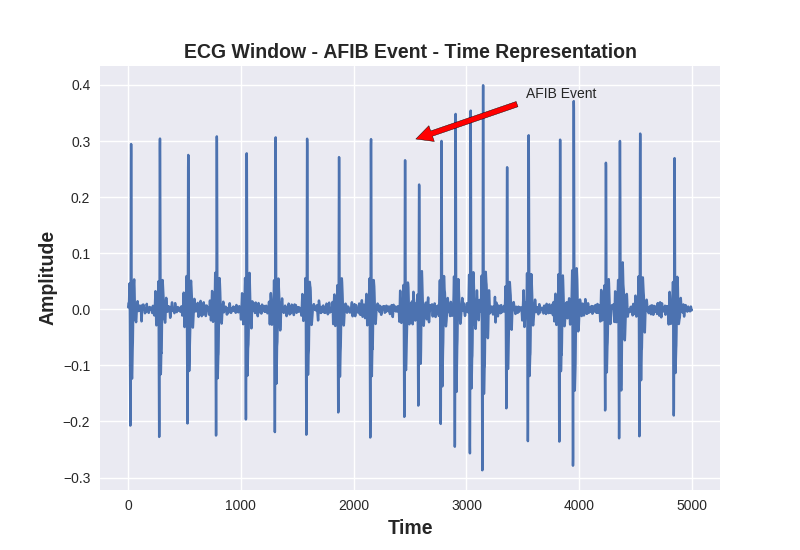

In [21]:
%matplotlib notebook
seconds_before = 10 # How many seconds before the AFIB event starts
seconds_after = 10 # How many seconds after the AFIB event starts

#Change the domain from seconds to samples
samples_before = seconds_before * Fs 
samples_after = seconds_after * Fs

sample_event = 1097510 #Sample where the first AFIB event has started
ECG_afib = ECGf_2[sample_event-samples_before : sample_event+samples_after]

plt.plot(ECG_afib)
plt.title('ECG Window - AFIB Event - Time Representation', fontsize = 14, fontweight = 'bold')
plt.xlabel('Time', fontsize = 14,fontweight = 'bold')
plt.ylabel('Amplitude', fontsize = 14,fontweight = 'bold')

plt.annotate('AFIB Event', xy=(samples_before, 0.3),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='red', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )
plt.show()

<IPython.core.display.Javascript object>


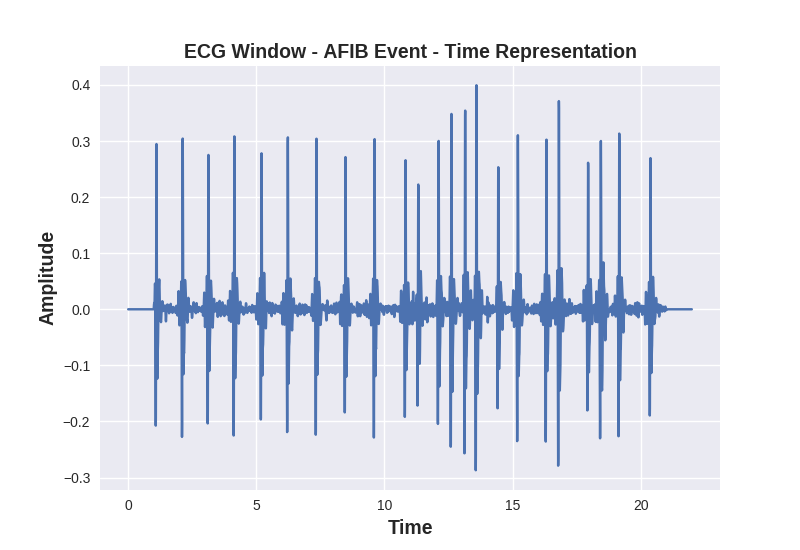

<IPython.core.display.Javascript object>


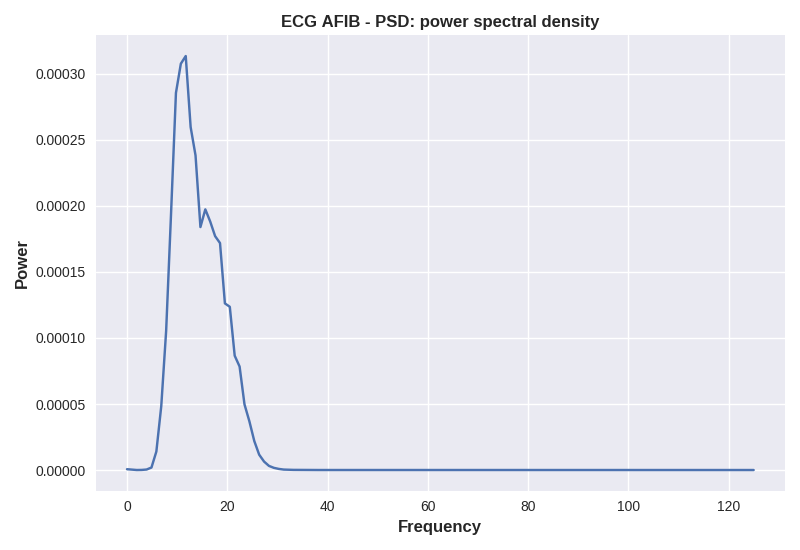

<IPython.core.display.Javascript object>


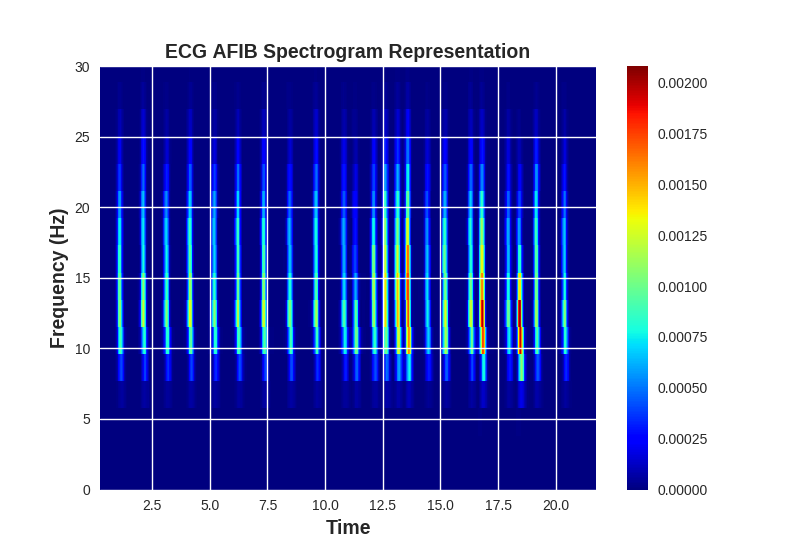

<IPython.core.display.Javascript object>


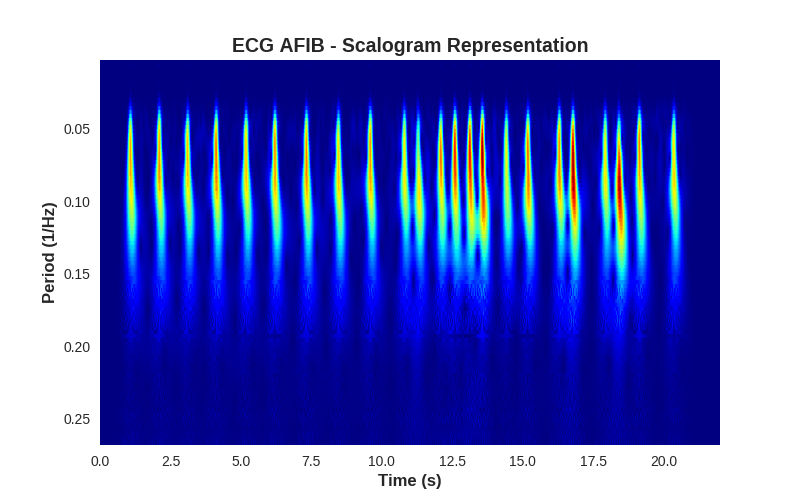

Text(0.5, 1.0, 'ECG AFIB - Scalogram Representation')

In [22]:
%matplotlib notebook

N=Fs
ECG_afib = np.pad(ECG_afib,(N,N), 'constant')

wavelet = 'cmor1-1.5'   #Wavelet-mother
scale = np.arange(1, 100, 1)   #The scale parameter its how we will dilate the wavelet onto the signal
time = np.arange(len(ECG_afib))*(1/Fs) #Time represents how we'd like the time representation

#Plot ECG in time domain
fig = plt.figure()
plt.plot(time,ECG_afib)
plt.title('ECG Window - AFIB Event - Time Representation', fontsize = 14, fontweight = 'bold')
plt.xlabel('Time', fontsize = 14,fontweight = 'bold')
plt.ylabel('Amplitude', fontsize = 14,fontweight = 'bold')

#Create and plot PSD
fig_3 = plt.figure()
freqs, psd = signal.welch(ECG_afib, fs=Fs)

plt.plot(freqs, psd)
plt.title('ECG AFIB - PSD: power spectral density', fontsize = 12,fontweight = 'bold')
plt.xlabel('Frequency', fontsize = 12,fontweight = 'bold')
plt.ylabel('Power', fontsize = 12,fontweight = 'bold')
plt.tight_layout() 

#Plot the Spectrogram
fig_4 = plt.figure()
plt.specgram(ECG_afib,NFFT=128, Fs=Fs, noverlap=120, scale='linear', cmap='jet')
plt.colorbar()
plt.title('ECG AFIB Spectrogram Representation', fontsize = 14, fontweight = 'bold')
plt.xlabel('Time', fontsize = 14,fontweight = 'bold')
plt.ylabel('Frequency (Hz)', fontsize = 14,fontweight = 'bold')
plt.ylim(0,30)
plt.show()

#Create Scalogram 
ax2 = scg.cws(time, ECG_afib, scales=scale, wavelet=wavelet,\
            figsize=(8, 5),yaxis='period', cmap="jet", cbar=None, coi=False, ylabel='', xlabel='',\
            title='Scalogram Representation')
ax2.set_xlabel('Time (s)', fontsize = 12,fontweight = 'bold')
ax2.set_ylabel('Period (1/Hz)', fontsize = 12,fontweight = 'bold')
ax2.set_title('ECG AFIB - Scalogram Representation', fontsize = 14, fontweight = 'bold')

